In [0]:
import pandas as pd


In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
pip install scikit-plot

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = '/content/drive/My Drive/'
data=pd.read_csv(path+"train.csv")

In [0]:
data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [0]:
import numpy as np
import re
import string
import pandas as pd
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
from gensim import utils
from nltk.corpus import stopwords


def textClean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", str(text))
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return (text)


def cleanup(text):
    text = textClean(text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text


def constructLabeledSentences(data):
    sentences = []
    for index, row in data.iteritems():
        sentences.append(LabeledSentence(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences


def getEmbeddings(path,vector_dimension=300,):
    data = pd.read_csv(path+"train.csv")
    print("*")

    missing_rows = []
    for i in range(len(data)):
        if data.loc[i, 'text'] != data.loc[i, 'text']:
            missing_rows.append(i)
    data = data.drop(missing_rows).reset_index().drop(['index','id'],axis=1)
    

    for i in range(len(data)):
        data.loc[i, 'text'] = cleanup(data.loc[i,'text'])

    x = constructLabeledSentences(data['text'])
    y = data['label'].values

    text_model = Doc2Vec(min_count=1, window=5, vector_size=vector_dimension, sample=1e-4, negative=5, workers=7, epochs=10,
                         seed=1)
    text_model.build_vocab(x)
    text_model.train(x, total_examples=text_model.corpus_count, epochs=text_model.iter)

    train_size = int(0.8 * len(x))
    test_size = len(x) - train_size

    text_train_arrays = np.zeros((train_size, vector_dimension))
    text_test_arrays = np.zeros((test_size, vector_dimension))
    train_labels = np.zeros(train_size)
    test_labels = np.zeros(test_size)

    for i in range(train_size):
        text_train_arrays[i] = text_model.docvecs['Text_' + str(i)]
        train_labels[i] = y[i]

    j = 0
    for i in range(train_size, train_size + test_size):
        text_test_arrays[j] = text_model.docvecs['Text_' + str(i)]
        test_labels[j] = y[i]
        j = j + 1

    return text_train_arrays, text_test_arrays, train_labels, test_labels

NameError: ignored

Using TensorFlow backend.


*
ah


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               77056     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 80)                20560     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 162       
Total params: 163,570
Trainable params: 163,570
Non-trainable params: 0
________________________________________________

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


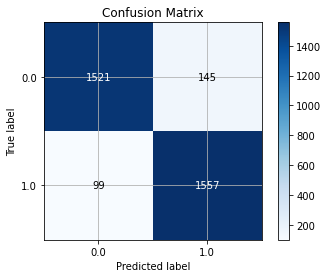

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Input, RepeatVector
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import scikitplot.plotters as skplt


def plot_cmat(yte, ypred):
    '''Plotting confusion matrix'''
    skplt.plot_confusion_matrix(yte, ypred)
    plt.show()


xtr,xte,ytr,yte = getEmbeddings(path)
np.save('./xtr', xtr)
np.save('./xte', xte)
np.save('./ytr', ytr)
np.save('./yte', yte)

xtr = np.load('./xtr.npy')
xte = np.load('./xte.npy')
ytr = np.load('./ytr.npy')
yte = np.load('./yte.npy')


def baseline_model():
    '''Neural network with 3 hidden layers'''
    model = Sequential()
    model.add(Dense(256, input_dim=300, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.5))
    model.add(Dense(80, activation='relu', kernel_initializer='normal'))
    model.add(Dense(2, activation="softmax", kernel_initializer='normal'))

    # gradient descent
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    
    # configure the learning process of the model
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model


model = baseline_model()
model.summary()
x_train, x_test, y_train, y_test = train_test_split(xtr, ytr, test_size=0.2, random_state=42)
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y = np_utils.to_categorical((label_encoder.transform(y_train)))
label_encoder.fit(y_test)
encoded_y_test = np_utils.to_categorical((label_encoder.transform(y_test)))
estimator = model.fit(x_train, encoded_y, epochs=20, batch_size=64)
print("Model Trained!")
score = model.evaluate(x_test, encoded_y_test)
print("")
print("Accuracy = " + format(score[1]*100, '.2f') + "%")   # 92.69%

probabs = model.predict_proba(x_test)
y_pred = np.argmax(probabs, axis=1)
 
plot_cmat(y_test, y_pred)

In [0]:
abel_encoder = LabelEncoder()
label_encoder.fit(yte)
encoded_y = np_utils.to_categorical((label_encoder.transform(yte)))

score = model.evaluate(xte, encoded_y)
print("")
print("Accuracy = " + format(score[1]*100, '.2f') + "%")   # 92.69%


4153/4153 [==============================] - 0s 32us/step

Accuracy = 92.17%


In [0]:
print(xte.shape)
print(xtr.shape)

(4153, 300)
(16608, 300)


In [0]:
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from collections import Counter
import os
#import getEmbeddings2
import matplotlib.pyplot as plt
import scikitplot.plotters as skplt


top_words = 5000
epoch_num = 5
batch_size = 64

def plot_cmat(yte, ypred):
    '''Plotting confusion matrix'''
    skplt.plot_confusion_matrix(yte, ypred)
    plt.show()

if not os.path.isfile('./xtr_shuffled.npy') or \
    not os.path.isfile('./xte_shuffled.npy') or \
    not os.path.isfile('./ytr_shuffled.npy') or \
    not os.path.isfile('./yte_shuffled.npy'):
    getEmbeddings(path)
    #getEmbeddings.clean_data()


xtr = np.load('./xtr_shuffled.npy')
xte = np.load('./xte_shuffled.npy')
y_train = np.load('./ytr_shuffled.npy')
y_test = np.load('./yte_shuffled.npy')

cnt = Counter()
x_train = []
for x in xtr:
    x_train.append(x.split())
    for word in x_train[-1]:
        cnt[word] += 1  

# Storing most common words
most_common = cnt.most_common(top_words + 1)
word_bank = {}
id_num = 1
for word, freq in most_common:
    word_bank[word] = id_num
    id_num += 1

# Encode the sentences
for news in x_train:
    i = 0
    while i < len(news):
        if news[i] in word_bank:
            news[i] = word_bank[news[i]]
            i += 1
        else:
            del news[i]

y_train = list(y_train)
y_test = list(y_test)

# Delete the short news
i = 0
while i < len(x_train):
    if len(x_train[i]) > 10:
        i += 1
    else:
        del x_train[i]
        del y_train[i]

# Generating test data
x_test = []
for x in xte:
    x_test.append(x.split())

# Encode the sentences
for news in x_test:
    i = 0
    while i < len(news):
        if news[i] in word_bank:
            news[i] = word_bank[news[i]]
            i += 1
        else:
            del news[i]


# Truncate and pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

# Convert to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# Create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+2, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epoch_num, batch_size=batch_size)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy= %.2f%%" % (scores[1]*100))

# Draw the confusion matrix
y_pred = model.predict_classes(X_test)
plot_cmat(y_test, y_pred)

*
ah


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


FileNotFoundError: ignored

*
ah


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


Accuracy = 72.04%


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


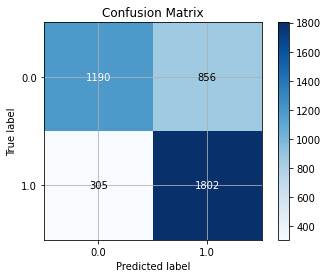

In [0]:
#from getEmbeddings import getEmbeddings
from sklearn.naive_bayes import GaussianNB
import numpy as np
import matplotlib.pyplot as plt
import scikitplot.plotters as skplt


def plot_cmat(yte, ypred):
    '''Plotting confusion matrix'''
    skplt.plot_confusion_matrix(yte,ypred)
    plt.show()


xtr,xte,ytr,yte = getEmbeddings(path)
np.save('./xtr', xtr)
np.save('./xte', xte)
np.save('./ytr', ytr)
np.save('./yte', yte)

xtr = np.load('./xtr.npy')
xte = np.load('./xte.npy')
ytr = np.load('./ytr.npy')
yte = np.load('./yte.npy')

gnb = GaussianNB()
gnb.fit(xtr,ytr)
y_pred = gnb.predict(xte)
m = yte.shape[0]
n = (yte != y_pred).sum()
print("Accuracy = " + format((m-n)/m*100, '.2f') + "%")   # 72.94%

plot_cmat(yte, y_pred)

*
ah


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


Accuracy = 91.84%


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


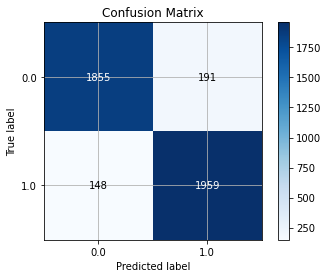

In [0]:
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import scikitplot.plotters as skplt


def plot_cmat(yte, ypred):
    '''Plotting confusion matrix'''
    skplt.plot_confusion_matrix(yte,ypred)
    plt.show()


xtr,xte,ytr,yte = getEmbeddings(path)
np.save('./xtr', xtr)
np.save('./xte', xte)
np.save('./ytr', ytr)
np.save('./yte', yte)

xtr = np.load('./xtr.npy')
xte = np.load('./xte.npy')
ytr = np.load('./ytr.npy')
yte = np.load('./yte.npy')

clf = SVC()
clf.fit(xtr, ytr)
y_pred = clf.predict(xte)
m = yte.shape[0]
n = (yte != y_pred).sum()
print("Accuracy = " + format((m-n)/m*100, '.2f') + "%")   # 88.42%

plot_cmat(yte, y_pred)

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Input, RepeatVector
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import scikitplot.plotters as skplt
from keras import layers
from keras.models import Sequential


def plot_cmat(yte, ypred):
    '''Plotting confusion matrix'''
    skplt.plot_confusion_matrix(yte, ypred)
    plt.show()


xtr,xte,ytr,yte = getEmbeddings(path)
np.save('./xtr', xtr)
np.save('./xte', xte)
np.save('./ytr', ytr)
np.save('./yte', yte)

xtr = np.load('./xtr.npy')
xte = np.load('./xte.npy')
ytr = np.load('./ytr.npy')
yte = np.load('./yte.npy')


def baseline_model():
    model = Sequential(
     [
        # part 1: word and sequence processing
    
        layers.Conv1D(128, 5, activation='relu',input_shape=(16608, 300)),
        layers.GlobalMaxPooling1D(),
        
        # part 2: classification
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
    return model
    


model = baseline_model()

x_train, x_test, y_train, y_test = train_test_split(xtr, ytr, test_size=0.2, random_state=42)
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y = np_utils.to_categorical((label_encoder.transform(y_train)))
label_encoder.fit(y_test)
encoded_y_test = np_utils.to_categorical((label_encoder.transform(y_test)))
estimator = model.fit(x_train, encoded_y, epochs=20, batch_size=64)
model.summary()
print("Model Trained!")
score = model.evaluate(x_test, encoded_y_test)
print("")
print("Accuracy = " + format(score[1]*100, '.2f') + "%")   # 92.69%

probabs = model.predict_proba(x_test)
y_pred = np.argmax(probabs, axis=1)
 
plot_cmat(y_test, y_pred)

*
ah


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


ValueError: ignored

neeche wale code main Adadelta wala result use krna yeh CNN ka hai 


Epoch 1/20
13286/13286 [==============================] - 5s 383us/step - loss: 0.6838 - accuracy: 0.5962
Epoch 2/20
13286/13286 [==============================] - 5s 381us/step - loss: 0.6728 - accuracy: 0.6281
Epoch 3/20
13286/13286 [==============================] - 5s 376us/step - loss: 0.6660 - accuracy: 0.6277
Epoch 4/20
13286/13286 [==============================] - 5s 374us/step - loss: 0.6613 - accuracy: 0.6290
Epoch 5/20
13286/13286 [==============================] - 5s 374us/step - loss: 0.6580 - accuracy: 0.6287
Epoch 6/20
13286/13286 [==============================] - 5s 381us/step - loss: 0.6548 - accuracy: 0.6307
Epoch 7/20
13286/13286 [==============================] - 5s 381us/step - loss: 0.6520 - accuracy: 0.6322
Epoch 8/20
13286/13286 [==============================] - 5s 377us/step - loss: 0.6493 - accuracy: 0.6350
Epoch 9/20
13286/13286 [==============================] - 5s 382us/step - loss: 0.6464 - accuracy: 0.6376
Epoch 10/20
13286/13286 [=====================

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


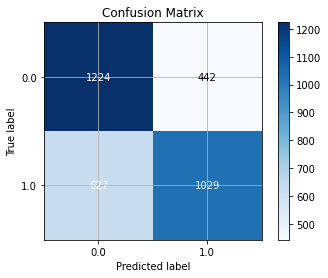

Epoch 1/20
13286/13286 [==============================] - 5s 389us/step - loss: 0.6526 - accuracy: 0.6255
Epoch 2/20
13286/13286 [==============================] - 5s 389us/step - loss: 0.6021 - accuracy: 0.6693
Epoch 3/20
13286/13286 [==============================] - 5s 384us/step - loss: 0.5791 - accuracy: 0.6902
Epoch 4/20
13286/13286 [==============================] - 5s 387us/step - loss: 0.5676 - accuracy: 0.6953
Epoch 5/20
13286/13286 [==============================] - 5s 380us/step - loss: 0.5625 - accuracy: 0.7044
Epoch 6/20
13286/13286 [==============================] - 5s 382us/step - loss: 0.5592 - accuracy: 0.7036
Epoch 7/20
13286/13286 [==============================] - 5s 376us/step - loss: 0.5582 - accuracy: 0.7077
Epoch 8/20
13286/13286 [==============================] - 5s 387us/step - loss: 0.5569 - accuracy: 0.7104
Epoch 9/20
13286/13286 [==============================] - 5s 390us/step - loss: 0.5530 - accuracy: 0.7098
Epoch 10/20
13286/13286 [=====================

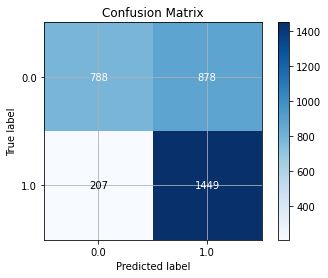

Epoch 1/20
13286/13286 [==============================] - 5s 390us/step - loss: 0.6527 - accuracy: 0.6259
Epoch 2/20
13286/13286 [==============================] - 5s 385us/step - loss: 0.5984 - accuracy: 0.6794
Epoch 3/20
13286/13286 [==============================] - 5s 383us/step - loss: 0.5723 - accuracy: 0.6960
Epoch 4/20
13286/13286 [==============================] - 5s 386us/step - loss: 0.5577 - accuracy: 0.7102
Epoch 5/20
13286/13286 [==============================] - 5s 378us/step - loss: 0.5512 - accuracy: 0.7139
Epoch 6/20
13286/13286 [==============================] - 5s 380us/step - loss: 0.5496 - accuracy: 0.7149
Epoch 7/20
13286/13286 [==============================] - 5s 389us/step - loss: 0.5459 - accuracy: 0.7177
Epoch 8/20
13286/13286 [==============================] - 5s 385us/step - loss: 0.5445 - accuracy: 0.7192
Epoch 9/20
13286/13286 [==============================] - 5s 387us/step - loss: 0.5376 - accuracy: 0.7269
Epoch 10/20
13286/13286 [=====================

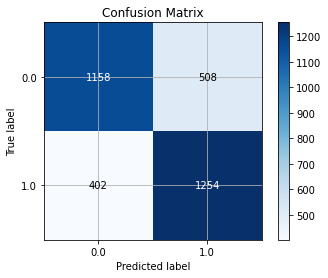

Epoch 1/20
13286/13286 [==============================] - 5s 387us/step - loss: 0.6486 - accuracy: 0.6219
Epoch 2/20
13286/13286 [==============================] - 5s 373us/step - loss: 0.6105 - accuracy: 0.6578
Epoch 3/20
13286/13286 [==============================] - 5s 373us/step - loss: 0.5941 - accuracy: 0.6783
Epoch 4/20
13286/13286 [==============================] - 5s 374us/step - loss: 0.5828 - accuracy: 0.6802
Epoch 5/20
13286/13286 [==============================] - 5s 372us/step - loss: 0.5714 - accuracy: 0.6967
Epoch 6/20
13286/13286 [==============================] - 5s 377us/step - loss: 0.5619 - accuracy: 0.7034
Epoch 7/20
13286/13286 [==============================] - 5s 371us/step - loss: 0.5579 - accuracy: 0.7047
Epoch 8/20
13286/13286 [==============================] - 5s 375us/step - loss: 0.5570 - accuracy: 0.7075
Epoch 9/20
13286/13286 [==============================] - 5s 373us/step - loss: 0.5504 - accuracy: 0.7101
Epoch 10/20
13286/13286 [=====================

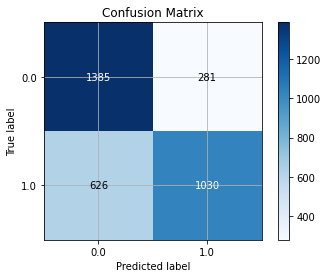

Epoch 1/20
13286/13286 [==============================] - 5s 377us/step - loss: 0.6463 - accuracy: 0.6390
Epoch 2/20
13286/13286 [==============================] - 5s 369us/step - loss: 0.5979 - accuracy: 0.6804
Epoch 3/20
13286/13286 [==============================] - 5s 368us/step - loss: 0.5756 - accuracy: 0.6972
Epoch 4/20
13286/13286 [==============================] - 5s 371us/step - loss: 0.5643 - accuracy: 0.7102
Epoch 5/20
13286/13286 [==============================] - 5s 370us/step - loss: 0.5576 - accuracy: 0.7110
Epoch 6/20
13286/13286 [==============================] - 5s 373us/step - loss: 0.5524 - accuracy: 0.7165
Epoch 7/20
13286/13286 [==============================] - 5s 377us/step - loss: 0.5492 - accuracy: 0.7184
Epoch 8/20
13286/13286 [==============================] - 5s 380us/step - loss: 0.5458 - accuracy: 0.7213
Epoch 9/20
13286/13286 [==============================] - 5s 377us/step - loss: 0.5441 - accuracy: 0.7193
Epoch 10/20
13286/13286 [=====================

In [0]:
a=['SGD','RMSprop','Adam','Adadelta','Adagrad','Adamax','Nadam']
j=['categorical_crossentropy','SparseCategoricalCrossentropy' ,'Poisson' ,'binary_crossentropy','categorical_crossentropy','sparse_categorical_crossentropy' 
, 'poisson']

def baseline_model():
    model = Sequential(
     [
        # part 1: word and sequence processing
    
        layers.Conv1D(128, 5, activation='relu',input_shape=(300,1)),
        layers.GlobalMaxPooling1D(),
        
        # part 2: classification
        layers.Dense(128, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])
    model.compile(loss=j[n],
              optimizer=a[i],
              metrics=['accuracy'])
    return model
    
for n in range(0,len(j)):
  for i in range(0,len(a)):
    model = baseline_model()
    x_train, x_test, y_train, y_test = train_test_split(tr, ytr, test_size=0.2, random_state=42)
    label_encoder = LabelEncoder()
    label_encoder.fit(y_train)
    encoded_y = np_utils.to_categorical((label_encoder.transform(y_train)))
    label_encoder.fit(y_test)
    encoded_y_test = np_utils.to_categorical((label_encoder.transform(y_test)))
    estimator = model.fit(x_train, encoded_y, epochs=20, batch_size=64)
    model.summary()
    print("Model Trained!")
    score = model.evaluate(x_test, encoded_y_test)
    print("")
    print("Accuracy = "+ a[i] + format(score[1]*100, '.2f') + "%")   # 92.69%
    probabs = model.predict_proba(x_test)
    y_pred = np.argmax(probabs, axis=1)
    plot_cmat(y_test, y_pred)

In [0]:
tr=np.expand_dims(X, axis=2)



In [0]:
from keras import layers
from keras.models import Sequential
xte = np.expand_dims(X, axis=2)
model = Sequential(
    [
        
        layers.Conv1D(128, 5, activation='relu'),
        layers.Conv1D(in)
        layers.GlobalMaxPooling1D(),
        
        # part 2: classification
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

SyntaxError: ignored

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Input, RepeatVector
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import scikitplot.plotters as skplt


def plot_cmat(yte, ypred):
    '''Plotting confusion matrix'''
    skplt.plot_confusion_matrix(yte, ypred)
    plt.show()


xtr,xte,ytr,yte = getEmbeddings(path)


def baseline_model():
    '''Neural network with 3 hidden layers'''
    model = Sequential()
    model.add(Dense(256, input_dim=300, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.5))
    model.add(Dense(80, activation='relu', kernel_initializer='normal'))
    model.add(Dense(1, activation="sigmoid", kernel_initializer='normal'))

    # gradient descent
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    
    # configure the learning process of the model
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model


model = baseline_model()
model.summary()
x_train, x_test, y_train, y_test = train_test_split(xtr, ytr, test_size=0.2, random_state=42)
#from keras.utils import to_categorical
#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)
#estimator = model.fit(x_train, y_train, epochs=20, batch_size=64)
print("Model Trained!")
score = model.evaluate(x_test, y_test)
print("")
print("Accuracy = " + format(score[1]*100, '.2f') + "%")   # 92.69%

probabs = model.predict_proba(x_test)

y_test=np.argmax(y_test, axis=1)
y_pred=np.argmax(probabs, axis=1) 

plot_cmat(y_test,y_pred)


*
ah


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 256)               77056     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 80)                20560     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 81        
Total params: 163,489
Trainable params: 163,489
Non-trainable params: 0
________________________________________________

AxisError: ignored

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
int64
float64
[1. 0. 1. 1. 0.]
[0 0 1 1 0]
[[5.5960792e-01 4.4039214e-01]
 [9.9862003e-01 1.3800039e-03]
 [1.1733598e-05 9.9998832e-01]
 [9.1131866e-02 9.0886807e-01]
 [9.9997878e-01 2.1180282e-05]]
[0 0 1 1 0]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


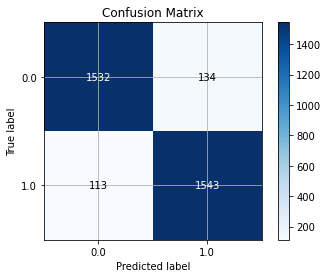

In [0]:
print(type(y_test))
print(type(y_pred))
print(y_pred.dtype)
print(y_test.dtype)
print(y_test[0:5])
print(y_pred[0:5])
print(probabs[0:5])
y_pred=np.argmax(probabs, axis=1)
print(y_pred[0:5])
plot_cmat(y_test,y_pred)